Image colorization project :
We train a CNN to take in greyscale images of ... and output their colorful and plausible colorization.

Imports required :

torch

skimage ? only used for rgb - lab parsing. Maybe we can do that ourselves to make some differentiation with the original project?

numpy

matplotlib

PIL ? only used to open images to rgb. We can use another library

In [609]:
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image
from skimage import color
from scipy.ndimage import gaussian_filter

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F

## Load data, augment it, transform it to LAB compute stats on colors

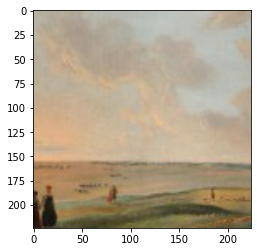

tensor([[[179, 180, 181,  ..., 179, 177, 176],
         [181, 182, 183,  ..., 180, 178, 176],
         [182, 183, 183,  ..., 179, 178, 177],
         ...,
         [ 42,  37,  39,  ...,  82,  74,  72],
         [ 44,  40,  42,  ...,  89,  82,  81],
         [ 45,  44,  46,  ...,  93,  89,  88]],

        [[179, 180, 179,  ..., 167, 166, 166],
         [180, 181, 180,  ..., 168, 168, 168],
         [180, 181, 180,  ..., 168, 168, 169],
         ...,
         [ 22,  22,  22,  ...,  94,  92,  94],
         [ 21,  24,  24,  ...,  92,  90,  92],
         [ 22,  26,  27,  ...,  91,  89,  90]],

        [[166, 167, 165,  ..., 151, 152, 152],
         [167, 168, 166,  ..., 152, 153, 153],
         [167, 167, 165,  ..., 152, 154, 155],
         ...,
         [ 15,  13,  15,  ...,  65,  60,  60],
         [ 16,  16,  18,  ...,  62,  59,  61],
         [ 18,  21,  22,  ...,  62,  60,  61]]], dtype=torch.uint8)


In [616]:
#Data loading
from torchvision import datasets, transforms, utils

transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.PILToTensor(),
])

dataset = datasets.ImageFolder("dataset_updated/training_set/train",transform=transform)
loader = data.DataLoader(dataset, batch_size = 4, shuffle = True)

images, labels = next(iter(loader))


img = images[0]
plt.imshow(transforms.functional.to_pil_image(img))
plt.show()
print(img)
img2 = img.numpy()

In [618]:
#LAB transform

def rgb2lab(img):
    #print(img.shape)
    img = img.transpose((1,2,0))
    return color.rgb2lab(img)  

rgb2lab(img2).shape

array([[[ 72.61268376,  -2.35043638,   6.64057797],
        [ 72.98138874,  -2.34844696,   6.63363671],
        [ 72.74737786,  -1.7955585 ,   7.40148622],
        ...,
        [ 69.08044275,   1.59785337,   9.83801274],
        [ 68.66945533,   1.55098768,   8.67696417],
        [ 68.5844227 ,   1.17519719,   8.54418052]],

       [[ 73.06050237,  -1.98571689,   6.75758809],
        [ 73.42874132,  -1.98416741,   6.75056241],
        [ 73.19593275,  -1.42956665,   7.5189713 ],
        ...,
        [ 69.45261965,   1.59419189,   9.82680258],
        [ 69.30593963,   1.0047065 ,   9.04301237],
        [ 69.13762342,   0.25491762,   8.7802718 ]],

       [[ 73.14004415,  -1.62237429,   6.88219007],
        [ 73.4840842 ,  -1.7931244 ,   7.38604636],
        [ 73.17202637,  -1.59970746,   8.03068259],
        ...,
        [ 69.36729294,   1.21722268,   9.69377645],
        [ 69.32965035,   1.16974145,   8.52476287],
        [ 69.53367161,   0.42001258,   8.25270236]],

       ...,

      

### Color stats

In [612]:
#Color stats (auxiliary functions)

def getDiscretisedColor(a,b,gridSize):
    a = np.round(a/gridSize) * gridSize
    b = np.round(b/gridSize) * gridSize
    return (a,b)

def getMatrixIndex(a,b,gridSize):
    i = (a + 500) / gridSize
    j = (b + 200) / gridSize
    return (int(i),int(j))

def getColorValue(i,j,gridSize):
    a = i * gridSize - 500
    b = j * gridSize - 200
    return (a,b)

In [613]:
#Color stats

# need dataset express like that: list of images (as tensor) with dim H x W x 2 ...
#image_test = rgb2lab(img2) # need to change dim order of color stat code... ?
#images = [np.random.rand(3,3,2) * 100]
#images = [image_test[:][:][1:2]]
#print(image_test.shape)
#print(images[0])

# Initialise the proba distribution of ab pairs in the images dataset (discretised).
gridSize = 10 # too big ?
colorProbabilities = np.zeros((1000 // gridSize, 400 // gridSize))

# Compute the proba distribution of the ab pairs in the images dataset (discretised).
nbOfAnalysedPixels = 0
for images in loader:
    for image in images[0]:
        image = image.numpy()
        image = rgb2lab(image)[:][:][1:2]
        for h in range (image.shape[0]):
            for w in range (image.shape[1]):
                (a,b) = getDiscretisedColor(image[h][w][0],image[h][w][1],gridSize)
                (i,j) = getMatrixIndex(a,b,gridSize)
                colorProbabilities[i][j] += 1
                nbOfAnalysedPixels += 1
colorProbabilities = colorProbabilities / nbOfAnalysedPixels

# Smooth the proba distribution of the ab pairs in the images dataset.
sigma = 5 # gaussian kernel parameter
#colorProbabilities = gaussian_filter(colorProbabilities, sigma=sigma) # is it ok ? add a lot of value in gamut... take proba treshold ?

# + display distribution in 2d plot ? like in paper (here, very simple)
plt.imshow(colorProbabilities, interpolation='none')
plt.xlim(10, 30) # need to be dynamic !
plt.ylim(40, 70)
plt.show()

# Get the vector of proba of ab pairs that are "in gamut"
inGamutColors = []
inGamutColorsProbas = []
for i in range (colorProbabilities.shape[0]):
    for j in range (colorProbabilities.shape[1]):
        currentColorPorba = colorProbabilities[i][j]
        if currentColorPorba >= 0.001: # put a treshold ? if we use smoothing 
            (a,b) = getColorValue(i,j,gridSize)
            inGamutColors.append((a,b))
            inGamutColorsProbas.append(currentColorPorba)
        
Q = len(inGamutColors) 
p_smooth = torch.tensor(inGamutColorsProbas)
print(Q)
print(inGamutColors)
print(inGamutColorsProbas)
Q = 1 # to remove


UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='dataset_updated/training_set/train/painting/1300.jpg'>

### Class rebalancing

In [ ]:
#Define pixel weight vector (class rebalancing)

# Set the parameters (from paper, need empirical value).
lambda_uniform = 1/2 

# Compute a smooth version of the empirical pixel color distribution.
#p_smooth = p # how to do that ? gaussian kernel ? done at previous cell...

# Compute the weight vector.
pixelsWeights = torch.reciprocal((1 - lambda_uniform) * p_smooth + lambda_uniform / Q)

# Normalise the weight vector according to p_smooth (E[W] = 1).
E_W = torch.sum(p_smooth * pixelsWeights)
scale_factor = 1 / E_W
pixelsWeights = scale_factor * pixelsWeights 

print(pixelsWeights)

## Define and instantiate Convolutional NN consistent with the description of the paper. Shown in table 4.

In [ ]:
#NN def

class ColorizationCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.l_cent = 50.
        self.l_norm = 100.
        self.ab_norm = 110.
        
        channels_block_1 = 64
        channels_block_2 = 128
        channels_block_3 = 256
        channels_block_4 = 512
        channels_block_5 = 512 #dilated
        channels_block_6 = 512 #dilated
        channels_block_7 = 512 
        channels_block_8 = 128 # transpose convolution necessary

        nb_colour_bins = 313
        # first conv block : 2 convs. from luminosity image to 64 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock1 = nn.Sequential(nn.Conv2d(1,channels_block_1,(3,3), padding =1), 
                nn.ReLU(True), #inplace for memory efficiency can be used as no skip connections are used.
                nn.Conv2d(channels_block_1,channels_block_1,(3,3), padding =1,stride=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_1) #normalization over the 64 channels created
        )

        # second conv block. 2 covs. from 64 features to 128 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock2 = nn.Sequential(nn.Conv2d(64,channels_block_2,(3,3), padding =1,), 
                nn.ReLU(True),
                nn.Conv2d(channels_block_2,channels_block_2,(3,3), padding =1,stride=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_2)
        )

        # third conv block. 3 convs. from 64 to 128 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock3 = nn.Sequential(nn.Conv2d(channels_block_2,channels_block_3,(3,3), padding = 1,), 
                nn.ReLU(True),
                nn.Conv2d(channels_block_3,channels_block_3,(3,3), padding =1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_3,channels_block_3,(3,3), padding =1,stride=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_3)
        )

        # fourth conv block. 3 convs. from 256 to 512 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock4 = nn.Sequential(nn.Conv2d(channels_block_3,channels_block_4,(3,3), padding =1,),
                nn.ReLU(True),
                nn.Conv2d(channels_block_4,channels_block_4,(3,3), padding = 1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_4,channels_block_4,(3,3), padding = 1), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_4)
        )
        
        #fifth conv block. 3 convs. no change in nb feature maps. 3x3 kernels with 2 dilation and 2 padding to not downscale. normalization at the end.

        self.convBlock5 = nn.Sequential(nn.Conv2d(channels_block_4,channels_block_5,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_5,channels_block_5,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_5,channels_block_5,(3,3),dilation=2,padding=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_5)
        )

        #sixth conv block. same as 5
        self.convBlock6 = nn.Sequential(nn.Conv2d(channels_block_5,channels_block_6,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_6,channels_block_6,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_6,channels_block_6,(3,3),dilation=2,padding=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_6)
        )

        #seventh conv block : 3 convs with 3x3 kernels.
        self.convBlock7 = nn.Sequential(nn.Conv2d(channels_block_6,channels_block_7,(3,3),padding =1,),
                nn.ReLU(True),
                nn.Conv2d(channels_block_7,channels_block_7,(3,3),padding =1,),
                nn.ReLU(True),
                nn.Conv2d(channels_block_7,channels_block_7,(3,3),padding =1,), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_7)
        )

        #eighth conv block : 1 inverse conv to upsample then 2 convs with 3x3 kernels default parameters. Final convolution with 1x1 for classification into a colour bin
        self.convBlock8 = nn.Sequential(nn.ConvTranspose2d(channels_block_7,channels_block_8,(4,4),stride = 2, padding =1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_8,channels_block_8,(3,3),padding = 1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_8,channels_block_8,(3,3),padding = 1), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.Conv2d(channels_block_8,nb_colour_bins,kernel_size=1) #1x1 kernel for classification in each colour bin (value will be soft maxed for probability)
        )

        self.outputLayer = nn.Conv2d(nb_colour_bins,2,kernel_size=1,dilation=1, bias = False) # 1x1 kernel to get 2 channel values of a and b respectively
    
    def forward(self, luminosity_image):
        h1 = self.convBlock1((luminosity_image-self.l_cent)/self.l_norm) #normalize luminosity to be on scale of 0 to 100
        h2 = self.convBlock2(h1)
        h3 = self.convBlock3(h2)
        h4 = self.convBlock4(h3)
        h5 = self.convBlock5(h4)
        h6 = self.convBlock6(h5)
        h7 = self.convBlock7(h6)
        h8 = self.convBlock8(h7)

        colour_bin_proba = (nn.Softmax(dim=1))(h8)
        output = self.outputLayer(colour_bin_proba)
        upscaled_output = (nn.Upsample(scale_factor=4, mode='bilinear'))(output) # bilinear upscale to agree with input image size 

        return upscaled_output * self.ab_norm # denormalize to cover whole ab value range
        
colCNN = ColorizationCNN()

## Define optimizer

In [ ]:
#ADAM
initial_lr = 3e-5
optimizer = torch.optim.Adam(colCNN.parameters(),lr = initial_lr , weight_decay=1e-3)
# lr will be decreased further when loss plateaus in the training loop. 

## Define Loss

### Soft encoding

In [ ]:
#Convert a true image Y[HxWx2] to pixels color distributions Z[HxWxQ] (soft encoding)

# Define a distance measure bewteen two colors (a,b).
colorDistance = lambda c1, c2: np.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2)


# Define a Gaussian kernel.
def gaussianKernel(distances):
    sigma = 5
    weights = np.exp(-(distances**2) / sigma)
    return weights


def getColorDistribution(Y,nbOfNeighbors):
    # Initiate a tensor to store the distributions produced from Y.
    Z = torch.zeros(Y.shape[0], Y.shape[1], Q)

    # Produce a color distribution for each pixel of the image.
    for h in range (Z.shape[0]):
        for w in range (Z.shape[1]):
            color_true = Y[h][w]
            distances = np.array([colorDistance(color,color_true) for color in inGamutColors])
            nearestNeighborsIndexs = (-distances).argsort()[:nbOfNeighbors]
            weights = gaussianKernel(distances[nearestNeighborsIndexs])
            for i in range (weights.size):
                Z[h][w][nearestNeighborsIndexs[i]] = weights[i]
    
    # Return the produced distributions.
    return Z

### Point estimate

In [ ]:
#Convert the pixel color distributions in Z[HxWxQ] to true picture estimate Y[HxWx2] (point estimate)

# No need to be very efficient because only use when we predict (after training) ? difficult to rewrite with tensor operation

def getPictureEstimate(Z,T):
    # Initiate a tensor to store the image estimated from Z.
    Y_estimate = torch.zeros(Z.shape[0], Z.shape[1], 2)
    
    # Estimate the Lab color for each pixel of the image.
    for h in range (Y_estimate.shape[0]):
        for w in range (Y_estimate.shape[1]):
            # Re-ajust the temperture of the current distribution.
            reajustedDistribution = torch.exp(torch.log10(Z[h][w]) / T)  / torch.sum(torch.exp(torch.log10(Z[h][w]) / T), 2) # check again...

            # Compute the anneled-mean of the current distribution. 
            a, b = 0, 0
            for q in range (Z.shape[2]):
                a += reajustedDistribution[q] * inGamutColors[q][0]
                b += reajustedDistribution[q] * inGamutColors[q][1]
            
            # Estimate the Lab color for the current pixel.
            Y_estimate[h][w][0] = a
            Y_estimate[h][w][1] = b
    
    # Return the estimated picture.
    return Y_estimate

### Loss function

In [ ]:
#v(Z_hw) weight in paper (section 2)

def getPixelsWeights(Z):
    W = torch.argmax(Z, dim=2)
    for i in range(W.size(dim=0)):
        for j in range(W.size(dim=1)):
            W[i,j] = pixelsWeights(W[i,j])

    return W

In [ ]:
#loss function 

def multinomialCrossEntropyLoss(Z_estimate, Z):
    W = getPixelsWeights(Z)
    L = - sum(W * torch.sum(Z * torch.log10(Z_estimate), dim=2))

    return L

## Main training loop and additional function TBD

Define a trining step: for each image in a batch : prediction, loss, backprop loss

In [ ]:
def training_step(optim,loss_fct,network,dataloader):

    iteration_losses = []

    for image in dataloader:

        predicted_colour_probability = network.forward(image)
        loss = loss_fct(predicted_colour_probability,getColorDistribution(data))
        iteration_losses.append(loss.item())

        optim.zero_grad() 
        loss.backward()
        optim.step()

    return sum(iteration_losses) / len(iteration_losses) # average loss of training iteration

In [ ]:
nb_steps = 1000
losses = np.zeros(nb_steps)


for step in range(nb_steps):
    print('step :',step,end='\r')
    losses[step] = training_step(optimizer,multinomialCrossEntropyLoss,colCNN,loader)


Plot losses

In [ ]:
x_axis = range(1,nb_steps)
plt.plot(x_axis,losses, label="train loss")

plt.xlabel('number of training steps')
plt.ylabel('avg loss')
plt.title('multinomial cross entropy loss')
plt.legend()
plt.show()

Show the neural network colorization of a specific image vs the real colors of that image